### Project Description
Pharmaceutical drugs have become an essential part of our health. Therefore, they need to be safe with little or no adverse effects.

You work with a non-profit that advocates for pharmaceutical drug safety. One of Its tasks is to create reports on drugs independent of the drug manufacturer. You'll conduct several hypothesis tests using Python to determine if the adverse reactions of a hypothetical drug are significant. You'll also check if factors such as age significantly influence the adverse reactions.

In [1]:
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
import pingouin as pg
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
drug_safety = pd.read_csv("drug_safety.csv")
drug_safety.head()

,age,sex,trx,week,wbc,rbc,adverse_effects,num_effects
0,62,male,Drug,0,7.3,5.1,No,0
1,62,male,Drug,1,NaN,NaN,No,0
2,62,male,Drug,12,5.6,5.0,No,0
3,62,male,Drug,16,NaN,NaN,No,0
4,62,male,Drug,2,6.6,5.1,No,0


In [4]:
# Checking for null values
drug_safety.isna().sum()

age                   0
sex                   0
trx                   0
week                  0
wbc                6975
rbc                6976
adverse_effects       0
num_effects           0
dtype: int64

In [5]:
# Filling null values with mean method
drug_safety['wbc'] = drug_safety['wbc'].fillna(drug_safety['wbc'].mean())
drug_safety['rbc'] = drug_safety['rbc'].fillna(drug_safety['rbc'].mean())

In [6]:
drug_safety.isna().sum()

age                0
sex                0
trx                0
week               0
wbc                0
rbc                0
adverse_effects    0
num_effects        0
dtype: int64

In [7]:
# Count the adverse_effects column values for each trx group
adv_eff_by_trx = drug_safety.groupby("trx").adverse_effects.value_counts()
adv_eff_by_trx

trx      adverse_effects
Drug     No                 9703
         Yes                1024
Placebo  No                 4864
         Yes                 512
Name: count, dtype: int64

In [8]:
# Compute total rows in each group
adv_eff_by_trx_totals = adv_eff_by_trx.groupby("trx").sum()
adv_eff_by_trx_totals

trx
Drug       10727
Placebo     5376
Name: count, dtype: int64

In [9]:
# Create an array of the "Yes" counts for each group
yeses = [adv_eff_by_trx["Drug"]["Yes"], adv_eff_by_trx["Placebo"]["Yes"]]
print(yeses)

[1024, 512]


In [10]:
# Create an array of the total number of rows in each group
n_rows = [adv_eff_by_trx_totals["Drug"], adv_eff_by_trx_totals["Placebo"]]
n_rows

[10727, 5376]

In [11]:
# Perform a two-sided z-test on the two proportions
two_sample_results = proportions_ztest(yeses, n_rows)
two_sample_results

(0.0452182684494942, 0.9639333330262475)

In [12]:
# Store the p-value
two_sample_p_value = two_sample_results[1]
two_sample_p_value

0.9639333330262475

In [14]:
# Determine if num_effects and trx are independent
num_effects_groups = pg.chi2_independence(
    data=drug_safety, x="num_effects", y="trx")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pingouin/contingency.py:151: UserWarning: Low count on observed frequencies.
  warnings.warn(f"Low count on {name} frequencies.")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pingouin/contingency.py:151: UserWarning: Low count on expected frequencies.
  warnings.warn(f"Low count on {name} frequencies.")


In [15]:
# Extract the p-value
num_effects_p_value = num_effects_groups[2]["pval"][0]
num_effects_p_value

0.6150123339426765

In [24]:
# First, let's examine the structure of your data
print("Unique values in 'num_effects':")
print(drug_safety["num_effects"].value_counts().sort_index())
print("\nUnique values in 'trx':")
print(drug_safety["trx"].value_counts())

Unique values in 'num_effects':
num_effects
0    14567
1     1442
2       88
3        6
Name: count, dtype: int64

Unique values in 'trx':
trx
Drug       10727
Placebo     5376
Name: count, dtype: int64


In [25]:
# Check the current contingency table shape
contingency_table = pd.crosstab(drug_safety["num_effects"], drug_safety["trx"])
print(f"\nCurrent contingency table shape: {contingency_table.shape}")
print("Current contingency table:")
print(contingency_table)


Current contingency table shape: (4, 2)
Current contingency table:
trx          Drug  Placebo
num_effects               
0            9703     4864
1             956      486
2              63       25
3               5        1


In [26]:
# Solution 1: Convert num_effects to binary (0 effects vs 1+ effects)
drug_safety["has_effects"] = (drug_safety["num_effects"] > 0).astype(int)
contingency_table_binary = pd.crosstab(drug_safety["has_effects"], drug_safety["trx"])

print(f"\nBinary contingency table shape: {contingency_table_binary.shape}")
print("Binary contingency table (0=No effects, 1=Has effects):")
print(contingency_table_binary)


Binary contingency table shape: (2, 2)
Binary contingency table (0=No effects, 1=Has effects):
trx          Drug  Placebo
has_effects               
0            9703     4864
1            1024      512


In [29]:
# Solution 2: If you want to compare specific effect counts (e.g., 0 vs 1 effects only)
# Filter data to include only rows with 0 or 1 effects
filtered_data = drug_safety[drug_safety["num_effects"].isin([0, 1])]
if len(filtered_data) > 0:
    contingency_table_filtered = pd.crosstab(filtered_data["num_effects"], filtered_data["trx"])
    print(f"\nFiltered contingency table shape (0 vs 1 effects only): {contingency_table_filtered.shape}")
    print("Filtered contingency table:")
    print(contingency_table_filtered)


Filtered contingency table shape (0 vs 1 effects only): (2, 2)
Filtered contingency table:
trx          Drug  Placebo
num_effects               
0            9703     4864
1             956      486


In [31]:
# Create 2x2 table by combining categories if needed
drug_safety["effect_binary"] = drug_safety["num_effects"].apply(
    lambda x: "No effects" if x == 0 else "Has effects"
)

In [33]:
contingency_table_final = pd.crosstab(drug_safety["effect_binary"], drug_safety["trx"])
print(f"Final 2x2 contingency table shape: {contingency_table_final.shape}")
print("Final 2x2 contingency table:")
print(contingency_table_final)

Final 2x2 contingency table shape: (2, 2)
Final 2x2 contingency table:
trx            Drug  Placebo
effect_binary               
Has effects    1024      512
No effects     9703     4864


In [36]:
# If you need the table as a numpy array for statistical tests
contingency_array = contingency_table_final.values
print(f"As numpy array shape: {contingency_array.shape}")
print("Array:")
print(contingency_array)

As numpy array shape: (2, 2)
Array:
[[1024  512]
 [9703 4864]]


In [35]:
# Run Fisher's exact test
fisher_result = stats.fisher_exact(contingency_table_final)
print("p-value:", fisher_result[1])

p-value: 0.9773134047112164


In [37]:
# Create the contingency table
# contingency_table = pd.crosstab(drug_safety["num_effects"], drug_safety["trx"])

# Run Fisher's exact test
fisher_result = stats.fisher_exact(contingency_array)
print("p-value:", fisher_result[1])

p-value: 0.9773134047112164


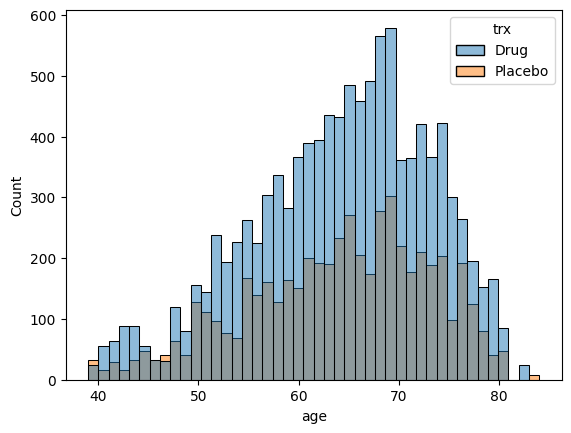

In [38]:
# Create a histogram with Seaborn
sns.histplot(data=drug_safety, x="age", hue="trx")
plt.show()

In [ ]:
Available Methods

'shapiro' (default)
Shapiro-Wilk test
Most powerful test for small to medium sample sizes (n < 50)
Good general-purpose choice

'normaltest'
D'Agostino and Pearson's test
Combines skewness and kurtosis tests
Works well for larger sample sizes

'jarque_bera'
Jarque-Bera test
Based on skewness and kurtosis
Commonly used in econometrics
Good for larger samples (n > 30)

'anderson'
Anderson-Darling test
More sensitive to deviations in the tails
Good alternative to Shapiro-Wilk

In [43]:
# Optionally - confirm the histogram's output by conducting a normality test
# To choose between unpaired t-test and Wilcoxon-Mann-Whitney test
normality = pg.normality(data=drug_safety, dv='age', group='trx', 
                         method='normaltest',  
                         alpha=0.05) # 0.05 is also the default
normality

,W,pval,normal
trx,,,
Drug,406.664169,4.943080e-89,False
Placebo,224.419000,1.853674e-49,False


In [44]:
# Select the age of the Drug group
age_trx = drug_safety.loc[drug_safety["trx"] == "Drug", "age"]
age_trx

0        62
1        62
2        62
3        62
4        62
         ..
16074    60
16075    60
16092    68
16093    68
16094    68
Name: age, Length: 10727, dtype: int64

In [45]:
# Select the age of the Placebo group
age_placebo = drug_safety.loc[drug_safety["trx"] == "Placebo", "age"]
age_placebo

32       73
33       73
34       73
35       73
36       73
         ..
16098    78
16099    78
16100    78
16101    78
16102    78
Name: age, Length: 5376, dtype: int64

In [46]:
# Since the data distribution is not normal
# Conduct a two-sided Mann-Whitney U test
age_group_effects = pg.mwu(age_trx, age_placebo)
age_group_effects

,U-val,alternative,p-val,RBC,CLES
MWU,29149339.5,two-sided,0.256963,0.01093,0.505465


In [47]:
# Extract the p-value
age_group_effects_p_value = age_group_effects["p-val"]
age_group_effects_p_value

MWU    0.256963
Name: p-val, dtype: float64